# Olfaction

**Summary:** In this tutorial, we will implement a simple controller for odor-guided taxis.

To interact with the world, we also made it possible for our model to detect odors emitted by objects in the simulation environment. The olfactory system in _Drosophila_ consists of specialized olfactory sensory neurons (OSNs) located in the antennae and maxillary palps. These detect specific odorant molecules and convey this information to the brain’s antennal lobe, where their signals are further processed. This is shown in the figure below (left, source: [Martin et al, 2013](https://doi.org/10.1002/ar.22747)) We emulated peripheral olfaction by attaching virtual odor sensors to the antennae and maxillary palps of our biomechanical model, as shown in the figure (right). The user has the option of configuring additional sensors at more precise locations on these olfactory organs. These virtual sensors can detect odor intensities across a multi-dimensional space that can be thought of as representing, for example, the concentrations of monomolecular chemicals sensed by OSNs in the antennae, or the intensities of composite odors co-activating numerous projection neurons in the antennal lobe.

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/olfaction.png?raw=true" alt="rule_based" width="600"/>

## Odor arena

To demonstrate odor sensing, let's create an environment with one attractive odor source and two aversive odor sources. The dimension of this odor space is 2 (attractive, aversive) despite the number of odor sources being 3. The odor sources share a peak intensity of 1. We will color the attractive odor source orange and the aversive odor sources blue.

In [1]:
import numpy as np

# random state seed for reproducibility
seed = 1

# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])

# Peak intensities: array of shape (num_odor_sources, odor_dimensions)
# For each odor source, if the intensity is (x, 0) then the odor is in the 1st dimension
# (in this case attractive). If it's (0, x) then it's in the 2nd dimension (in this case
# aversive)
peak_odor_intensity = np.array([[1, 0], [0, 1], [0, 1]])

# Marker colors: array of shape (num_odor_sources, 4) - RGBA values for each marker,
# normalized to [0, 1]
marker_colors = [[255, 127, 14], [31, 119, 180], [31, 119, 180]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])

odor_dimensions = len(peak_odor_intensity[0])

Let's create the arena using these parameters. The detailed documentation of the `OdorArena` class can be found in the [API reference](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.OdorArena). Its implementation is beyond the scope of this tutorial but can be found [here](https://github.com/NeLy-EPFL/flygym/blob/main/flygym/mujoco/arena/sensory_environment.py).

In [2]:
from flygym.mujoco.arena import OdorArena

arena = OdorArena(
    odor_source=odor_source,
    peak_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)

/Users/tom/miniconda3/envs/flygym/lib/python3.11/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/Users/tom/miniconda3/envs/flygym/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/Users/tom/miniconda3/envs/flygym/lib/python3.11/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https

Let’s place our fly in the arena. As before, we will run a few iterations to allow it to stand on the ground in a stable manner.

Note that we will be using the `HybridTurningNMF` as the turning controller. This class serves as an enhanced version of the `TurningNMF` in the previous exercises, utilizing sensory feedback to prevent the fly from stumbling. For further details, refer to https://neuromechfly.org/tutorials/hybrid_controller.html and https://neuromechfly.org/tutorials/turning.html.

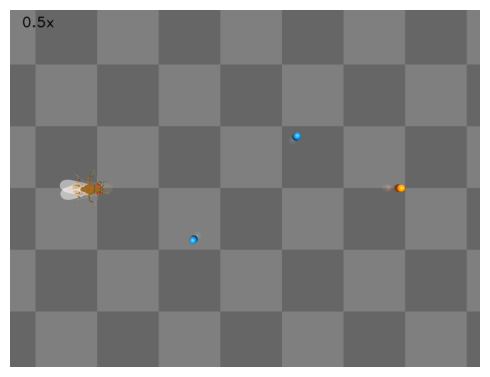

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


Path("./outputs").mkdir(exist_ok=True)


contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)
for i in range(500):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
fig.savefig("./outputs/olfaction_env.png")

## Controller for odor taxis

Let's design a simple hand-tuned controller for odor-guided taxis. We start by calculating the left-right asymmetry of the odor intensity $I$ for each odor $o$:

$$
\Delta I_o = \frac{I_\text{left,o} - I_\text{right,o}}{(I_\text{left,o} + I_\text{right,o}) / 2}
$$

Then, we multiply $\Delta I_o$ by a gain $\gamma_o$ for each odor dimension and take the sum $s$. Attractive and aversive odors will have different signs in their gains.

$$
s = \sum_{o} \gamma_o \Delta I_o
$$

We transform $s$ nonlinearly to avoid overly drastic turns when the asymmetry is subtle and to crop it within the range [0, 1). This gives us a turning bias $b$:

$$
b = \tanh(s^2)
$$

Finally, we modulate the descending signal $\delta$ based on $b$ and the sign of $s$:

$$
\delta_\text{left} = 
    \begin{cases}
    \delta_\text{max} & \text{if } s>0\\
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min})  & \text{otherwise}
    \end{cases}
    \qquad
    \delta_\text{right} = 
    \begin{cases}
    \delta_\text{max} - b(\delta_\text{max} - \delta_\text{min}) & \text{if } s>0\\
    \delta_\text{max}  & \text{otherwise}
    \end{cases}
$$

where, $\delta_\text{min}$, $\delta_\text{max}$ define the range of the descending signal. Here, we will use the following parameters:

- $\gamma_\text{attractive} = -500$ (negative ipsilateral gain leads to positive taxis)
- $\gamma_\text{aversive} = 80$ (positive ipsilateral gain leads to negative taxis)
- $\delta_\text{min} = 0.2$
- $\delta_\text{max} = 1$

As before, we will recalculate the steering signal every 0.05 seconds. Let's implement this in Python:

In [4]:
from tqdm import trange

# Gains for the two odors (negative = attractive, positive = aversive)
gains = np.array([-500, 80])
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

obs_hist = []
odor_history = []
obs, _ = sim.reset(seed)
for i in trange(num_decision_steps):
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])

    # Calculate the left-right asymmetry in the odor intensities
    I_l, I_r = I[:, 0], I[:, 1]
    denom = (I_l + I_r) / 2
    denom[denom == 0] = 1  # Avoid division by zero
    delta_I = (I_l - I_r) / denom

    # Calculate the weighted sum of the asymmetries for each odor
    s = np.dot(gains, delta_I)

    # Calculate the turning bias
    b = np.tanh(s**2)

    control_signal = np.ones((2,))
    side_to_modulate = int(s > 0)
    modulation_amount = b * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for j in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

    # Stop when the fly is within 2mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
        break

 63%|██████▎   | 63/100 [01:16<00:44,  1.21s/it]


We can visualize the fly trajectory:

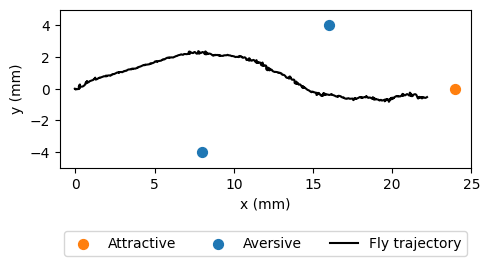

In [5]:
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [odor_source[0, 0]],
    [odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Attractive",
)
ax.scatter(
    [odor_source[1, 0]],
    [odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Aversive",
)
ax.scatter([odor_source[2, 0]], [odor_source[2, 1]], marker="o", color="tab:blue", s=50)
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
ax.set_aspect("equal")
ax.set_xlim(-1, 25)
ax.set_ylim(-5, 5)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig("./outputs/odor_taxis_trajectory.png")

We can also generate the video:

In [6]:
sim.save_video("./outputs/odor_taxis.mp4")

from IPython import display

display.Video("./outputs/odor_taxis.mp4")

# Exercise 3: Understanding the code

Read the first two lines of the main loop of the simulation.

```python
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])
```

What is the purpose of these two lines?

TODO: Your answer here

ANSWER:
`obs["odor_intensity"]` is of shape (# of odor dimensions, # of olfactory sensors).
The order of the olfactory sensors is (left maxillary palp, right maxillary palp, left antenna, right antenna).
`I_reshape` is of shape (# of odor dimensions, |{maxillary palp, antenna}|, |{left, right}|).
The second line calculates a weighted sum of the odor intensities sensed by the maxillary palps and the antennae. The weights were set to be `[120, 1200]` because the maxillary palp and the antenna has ~120 and ~1200 olfactory sensory neurons (OSNs), respectively. The shape of the resulting array, `I`, is (# of odor dimensions, |{left, right}|)

# Exercise 4: Odor from behind
In this exercise, let's simulate a scenario in which an attractive odor source is placed directly behind the fly.

In [7]:
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

#################################################################
# TODO: Create an odor arena with a single attractive odor source
# placed 3mm behind the fly
gains = np.array([-500, 80])

arena = OdorArena(
    odor_source=[[-3, 0, 1.5]],
    peak_intensity=[[1, 0]],
    diffuse_func=lambda x: x**-2,
    marker_colors=marker_colors,
    marker_size=0.3,
)
#################################################################

sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
)

In [8]:
obs, _ = sim.reset(seed)
for _ in trange(num_decision_steps):
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])
    denom = I.mean(1)
    denom[denom == 0] = 1
    delta_I = (I[:, 0] - I[:, 1]) / denom
    s = np.dot(gains, delta_I)
    b = np.tanh(s**2)
    control_signal = np.ones((2,))
    side_to_modulate = int(s > 0)
    modulation_amount = b * 0.8
    control_signal[side_to_modulate] -= modulation_amount

    for _ in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        sim.render()

    # Stop when the fly is within 2mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - arena.odor_source[0, :2]) < 2:
        break

sim.save_video("./outputs/behind.mp4")
display.Video("./outputs/behind.mp4")

100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Theoretically, when an odor source is placed directly behind the fly, the intensities of the odor detected by the left and right sensors should be the same, resulting in a zero turning bias. Despite this expectation, why does the fly appear to exhibit turning behavior in the video?

ANSWER: Upon beginning to walk, the fly will turn slightly to either the left or the right. Since the fly exhibits an unstable equilibrium in its turning tendency when the odor source is positioned directly behind it, any slight sideway deviation would increase the asymmetry in odor intensity, which leading to increased turning behavior.

Can you modify the code to reduce the turning radius?

In [9]:
obs, _ = sim.reset(seed)
for _ in trange(num_decision_steps):
    #################################################################
    # TODO: Modify the code to reduce the turning radius
    I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
    I = np.average(I_reshaped, axis=1, weights=[120, 1200])
    denom = I.mean(1)
    denom[denom == 0] = 1
    delta_I = (I[:, 0] - I[:, 1]) / denom
    s = np.dot(gains, delta_I)
    b = np.tanh(s**2)
    control_signal = np.ones((2,))
    side_to_modulate = int(s > 0)
    modulation_amount = b * 1.0
    control_signal[side_to_modulate] -= modulation_amount
    #################################################################

    for _ in range(physics_steps_per_decision_step):
        obs, _, _, _, _ = sim.step(control_signal)
        sim.render()

    # Stop when the fly is within 2mm of the attractive odor source
    if np.linalg.norm(obs["fly"][0, :2] - arena.odor_source[0, :2]) < 2:
        break

sim.save_video("./outputs/behind_tight_turn.mp4")
display.Video("./outputs/behind_tight_turn.mp4")

 53%|█████▎    | 53/100 [01:09<01:01,  1.30s/it]


# Exercise 5: Attraction vs aversion
Let's consider the case a fly is attracted to an object placed at (4, 2, 1.5):

100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Text(0.5, 1.0, 'Attraction')

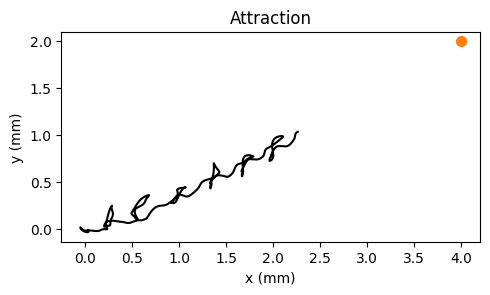

In [10]:
def run_simulation(
    odor_source,
    marker_colors,
    odor_gains,
    peak_odor_intensity,
    sim_params,
    run_time=1,
    decision_interval=0.05,
    NMF=HybridTurningNMF,
):
    num_decision_steps = int(run_time / decision_interval)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

    assert all(len(odor_gains) == len(i) for i in peak_odor_intensity)
    odor_dimensions = len(odor_gains)

    arena = OdorArena(
        odor_source=odor_source,
        peak_intensity=peak_odor_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    sim = NMF(
        sim_params=sim_params,
        arena=arena,
        spawn_pos=(0, 0, 0.2),
        contact_sensor_placements=contact_sensor_placements,
    )

    obs_hist = []
    obs, _ = sim.reset(seed)
    for _ in trange(num_decision_steps):
        I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
        I = np.average(I_reshaped, axis=1, weights=[120, 1200])
        denom = I.mean(1)
        denom[denom == 0] = 1
        delta_I = (I[:, 0] - I[:, 1]) / denom
        s = np.dot(odor_gains, delta_I)
        b = np.tanh(s**2)
        control_signal = np.ones((2,))
        side_to_modulate = int(s > 0)
        modulation_amount = b * 0.8
        control_signal[side_to_modulate] -= modulation_amount

        for _ in range(physics_steps_per_decision_step):
            obs, _, _, _, _ = sim.step(control_signal)
            sim.render()
            obs_hist.append(obs)

            # Stop when the fly is within 2mm of the attractive odor source
            if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
                break

    return obs_hist, sim


def plot_trajectory(obs_hist, odor_source, marker_colors):
    fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

    for (x, y), color in zip(odor_source[:, :2], marker_colors):
        ax.scatter(x, y, marker="o", color=color, s=50)

    ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory")
    ax.set_aspect("equal")
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")


odor_source = np.array([[4, 2, 1.5]])
marker_colors = np.array([[255, 127, 14, 255]]) / 255

obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 250]),
    sim_params=sim_params,
)
sim.save_video("./outputs/attraction.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Attraction")

Modify different parameters of `run_simulation` to make the fly avoid the odor source:

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Text(0.5, 1.0, 'Aversion 2')

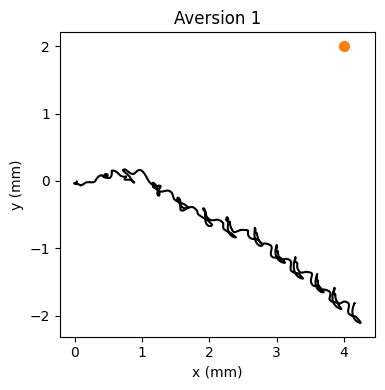

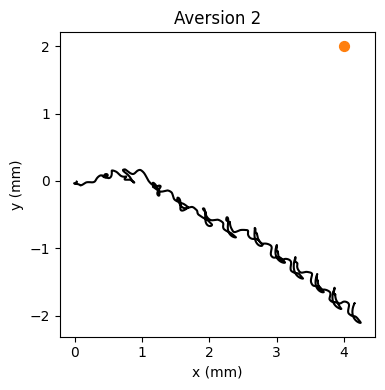

In [11]:
######################################################################
# TODO: Modify one parameter to make the fly avoid the odor source
obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[0, 1]]),
    odor_gains=np.array([-250, 250]),
    sim_params=sim_params,
)
######################################################################
sim.save_video("./outputs/aversion1.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Aversion 1")

######################################################################
# TODO: Modify another parameter to make the fly avoid the odor source
obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([250, -250]),
    sim_params=sim_params,
)
######################################################################
sim.save_video("./outputs/aversion2.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)
plt.title("Aversion 2")

Can you come up with other ways to make the fly avoid the odor source?

Answer: Change how the descending signals modulate the CPG parameters.

# Exercise 6: Noisy sensors
Let's see what happens when the measurements of odor intensity are noisy:

100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


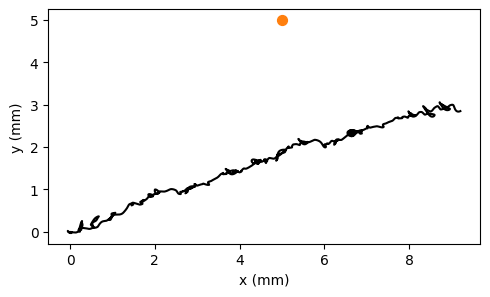

In [12]:
class HybridTurningNMFNoisy(HybridTurningNMF):
    def get_observation(self):
        obs = super().get_observation()
        rng = np.random.RandomState(round(self.curr_time / self.sim_params.timestep))
        # Inject multiplicative noise into the odor intensity
        obs["odor_intensity"] *= rng.uniform(0, 2, size=obs["odor_intensity"].shape)
        return obs


odor_source = np.array([[5, 5, 1.5]])
marker_colors = np.array([[255, 127, 14, 255]]) / 255

obs_hist, sim = run_simulation(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 0]),
    sim_params=sim_params,
    NMF=HybridTurningNMFNoisy,
    run_time=2,
)

sim.save_video("./outputs/noisy.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)

Let's implement a new control algorithm to make the fly turn toward the odor source more efficiently:

In [13]:
def run_simulation_new(
    odor_source,
    marker_colors,
    odor_gains,
    peak_odor_intensity,
    sim_params,
    run_time=1,
):
    assert all(len(odor_gains) == len(i) for i in peak_odor_intensity)
    odor_dimensions = len(odor_gains)

    arena = OdorArena(
        odor_source=odor_source,
        peak_intensity=peak_odor_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    sim = HybridTurningNMFNoisy(
        sim_params=sim_params,
        arena=arena,
        spawn_pos=(0, 0, 0.2),
        contact_sensor_placements=contact_sensor_placements,
    )

    obs_hist = []
    obs, _ = sim.reset(seed)

    s = None

    for _ in trange(int(run_time / sim_params.timestep)):
        I_reshaped = obs["odor_intensity"].reshape((odor_dimensions, 2, 2))
        I = np.average(I_reshaped, axis=1, weights=[120, 1200])
        denom = I.mean(1)
        denom[denom == 0] = 1
        delta_I = (I[:, 0] - I[:, 1]) / denom

        s_new = np.dot(odor_gains, delta_I)

        if s is None:
            s = s_new

        #################################################################
        # TODO: Calculate the exponential moving average of s
        # Refer to https://en.wikipedia.org/wiki/Exponential_smoothing
        alpha = 0.001
        s = (1 - alpha) * s + alpha * s_new
        #################################################################

        b = np.tanh(s**2)

        control_signal = np.ones((2,))
        side_to_modulate = int(s > 0)
        modulation_amount = b * 0.8
        control_signal[side_to_modulate] -= modulation_amount

        obs, _, _, _, _ = sim.step(control_signal)
        sim.render()
        obs_hist.append(obs)

        # Stop when the fly is within 2mm of the attractive odor source
        if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
            break

    return obs_hist, sim

 56%|█████▋    | 11284/20000 [00:28<00:22, 389.55it/s]


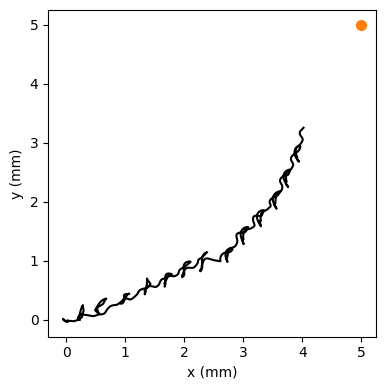

In [14]:
obs_hist, sim = run_simulation_new(
    odor_source=odor_source,
    marker_colors=marker_colors,
    peak_odor_intensity=np.array([[1, 0]]),
    odor_gains=np.array([-250, 0]),
    sim_params=sim_params,
    run_time=2,
)
sim.save_video("./outputs/smoothed.mp4")
plot_trajectory(obs_hist, odor_source, marker_colors)